In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

# PyTorch
import torch

from monai.utils import first

# MONAI
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    MaskIntensityd,
    ToTensord,
    ScaleIntensityd,
    ScaleIntensityRanged,
    RandAffined,
    RandFlipd,
    Rand2DElasticd,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandRicianNoised,
    RandBiasFieldd,
    RandGaussianNoised,
    RandSpatialCropd,
    SpatialPadd,
    SqueezeDimd,
    RandRotate90d
    
)
from monai.utils import set_determinism

# https://github.com/Project-MONAI/MONAI/issues/299

# Apply DA transformations before cropping

In [46]:
def load_images(directory_pelvis: str, device=None):
    """
    Load MRI and CT images, preprocess them, and return preprocessed pairs on the specified device.

    Args:
        directory_pelvis (str): Path to the dataset directory.
        device (torch.device): Device to which the tensors will be moved (e.g., 'cuda' or 'cpu').

    Returns:
        train_val_dataset: A dataset containing preprocessed 'mr' and 'ct' images for training and validation.
        test_dataset: A dataset containing preprocessed 'mr' and 'ct' images for testing.
    """

    if device is None:
        device = torch.device("cpu")

    dataset = []
    patient_folder_name = []

    for folder_patient in os.listdir(directory_pelvis):
        if folder_patient.lower() == "overview":
            continue

        patient_folder_name.append(folder_patient)
        patient_path = os.path.join(directory_pelvis, folder_patient)
        mri_path = os.path.join(patient_path, "mr.mha")
        ct_path = os.path.join(patient_path, "ct.mha")
        mask_path = os.path.join(patient_path, "mask.mha")

        if os.path.exists(mri_path) and os.path.exists(ct_path) and os.path.exists(mask_path):
            dataset.append({"mr": mri_path, "ct": ct_path, "mask": mask_path})
            
    set_determinism(seed=42)
    # Transformations common to all sets
    transforms = Compose(
        [
            LoadImaged(keys=["mr", "ct", "mask"]),
            EnsureChannelFirstd(keys=["mr", "ct", "mask"]),
            
            #SpatialPadd(keys=["mr", "ct", "mask"], spatial_size=(-1, -1, -1)),
            RandSpatialCropd(keys=["mr", "ct", "mask"], roi_size=(-1, -1, 1), random_size=False), # mantain the original size: C,H,W,D
            SqueezeDimd(keys=["mr", "ct", "mask"],dim=-1), # took D - C,H,W - 2D image
            
            # Intensity - MRI
            # Mimic an artifact common (one of the common) in MRI scans - gibbs artifacts, caused by limited k-space sampling
            # intensity of the gibbs noise filter - 1 value is randomly chosen from 0.6 to 0.8 - moderate to strong Gibbs artifact effect
            RandGibbsNoised(
                keys=["mr"], prob=1, alpha=(0.6, 0.8)
            ),
            # Intensity - MRI
            # Mimic spike artifacts: applies localized spikes in k-sapce
            RandKSpaceSpikeNoised(
                keys=["mr"],
                prob=0,
                # range of intensity for the spike artifacts
                intensity_range=(0.5, 1.0),
            ),
            # Intensity - MRI
            # Adds rician noise to image - thermal noise in the scanner
            RandRicianNoised(
                keys=["mr"],
                prob=0,
                mean=0.0,
                std=0.02,
                sample_std=True,
            ),
            # Intensity - MRI
            # Mimics the perturbations in the magnetic field
            RandBiasFieldd(
                keys=["mr"],
                prob=0,
                coeff_range=(0.02, 0.05),  # range of random coefficients
            ),
            # Intensity - MRI
            # Applies gaussian noise to images.
            RandGaussianNoised(
                keys=["mr"],
                prob=0,
                mean=0.0,
                std=0.05,
            ),
            
            
            SpatialPadd(keys=["mr", "ct", "mask"], spatial_size=(256, 256)),
            RandSpatialCropd(keys=["mr", "ct", "mask"], roi_size=(256, 256), random_size=False),
            
            ScaleIntensityd(keys=["mr"], minv=-1, maxv=1.0),
            ScaleIntensityRanged(
                keys=["ct"],
                a_min=-1024,
                a_max=3000,  # Clipping range for CT (-1024 HU = air, 1650 HU = bone)
                b_min=-1.0,
                b_max=1.0,
                clip=True,  # Normalization range
            ),
            MaskIntensityd(keys=["mr","ct"], mask_key="mask"),
            ToTensord(keys=["mr", "ct"])
        ]
        )

    monai_dataset = Dataset(
        data=dataset, transform=transforms
    )
        
    train_val_loader = DataLoader(monai_dataset, batch_size=4, collate_fn=pad_list_data_collate)
    
    return monai_dataset,train_val_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monai_dataset, train_val_loader = load_images("/home/catarina_caldeira/Imagens/SynthRAD2025/synthRAD2025_Task1_Train/Task1/AB", device=device)


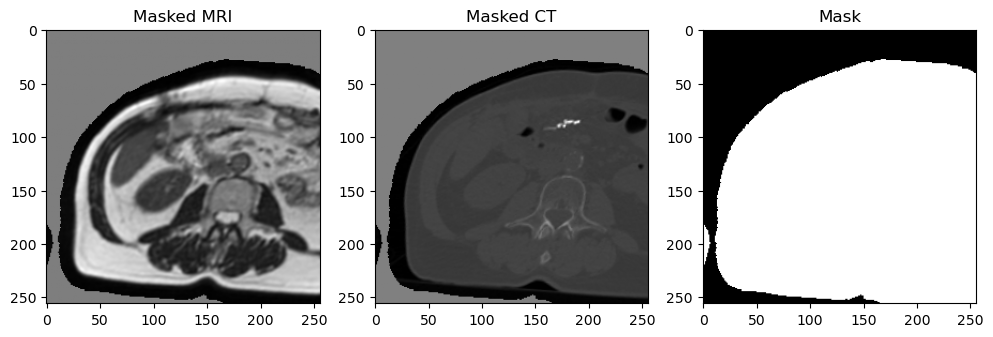

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(mr[0].cpu(), cmap="gray")
plt.title("Masked MRI")

plt.subplot(1,3,2)
plt.imshow(ct[0].cpu(), cmap="gray")
plt.title("Masked CT")

plt.subplot(1,3,3)
plt.imshow(mask[0].cpu(), cmap="gray")
plt.title("Mask")

plt.show()


metatensor([-1.0000, -1.0000, -1.0000,  ...,  0.9926,  0.9931,  1.0000])
metatensor([-1.0000, -0.9995, -0.9990,  ...,  0.0308,  0.0318,  0.0343])
metatensor([0., 1.])
MRI shape: (1, 256, 256)
CT shape: (1, 256, 256)
Mask shape: (1, 256, 256)


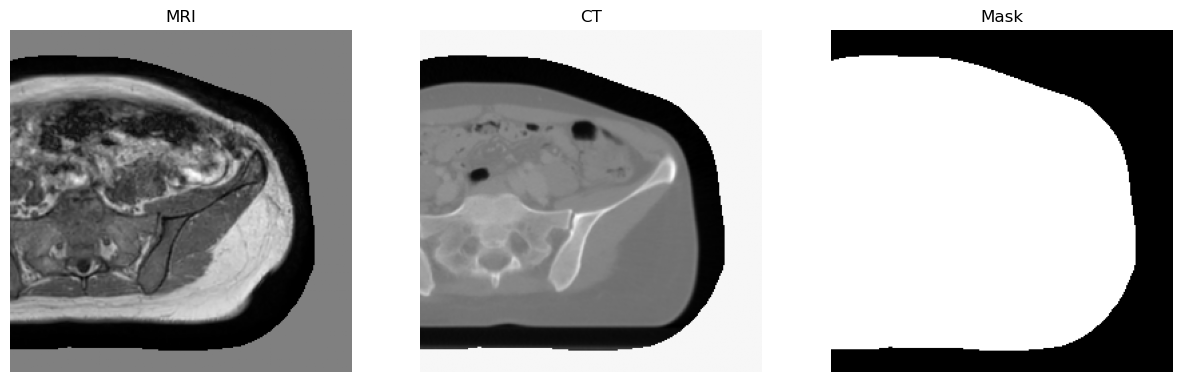

In [44]:
def visualize_image(mr_image, ct_image, mask_image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mr_image, cmap="gray")
    axes[0].set_title("MRI")
    axes[0].axis("off")

    axes[1].imshow(ct_image, cmap="gray")
    axes[1].set_title("CT")
    axes[1].axis("off")

    axes[2].imshow(mask_image, cmap="gray")
    axes[2].set_title("Mask")
    axes[2].axis("off")

    plt.show()

image = monai_dataset[1]
print(torch.unique(image['mr']))
print(torch.unique(image['ct']))
print(torch.unique(image['mask']))
mr_image = image['mr'].cpu().numpy() 
ct_image = image['ct'].cpu().numpy() 
mask_image = image['mask'].cpu().numpy() 

print("MRI shape:", mr_image.shape)
print("CT shape:", ct_image.shape)
print("Mask shape:", mask_image.shape)
    
# Seleciona o primeiro batch (batch = 0) para visualização
batch_idx = 0
mr_image = mr_image[0, :, :]  
ct_image = ct_image[0, :, :]  
mask_image = mask_image[0, :, :]
        
visualize_image(mr_image, ct_image, mask_image)